In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.6.5
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.1
matplotlib 2.1.2


## Chap.7 Ensemble learning and Random Forest

이 장은 모델의 알고리즘을 배우는 것이 아닌
모델을 학습시킨 후에 성능을 어떻게 향상시킬 것인가에 대한 내용을 다룬다.
그 방법으로 다양한 방법을 통해 다수의 모델들을 병합하여
성능을 끌어올리는 Ensemble 기법에 대해 알아보고자 한다.

Ensemble에는 크게 두 가지의 방법이 존재한다.
1. Voting : 각기 다른 훈련 알고리즘 병합(클래스에 의한 투표 or 확률)
2. Bagging & Pasting : 훈련 데이터의 Sampling을 통한 분류기를 각기 다르게 학습
3. Boosting : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 기법
4. Stacking : 예측값을 input으로 받아 최종 예측을 만드는 기법


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [3]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [4]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### 1. 투표기반 분류기

각 분류기가 약한 학습기(랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있다.

#### 큰 수의 법칙

Suppose 앞면이 나올 확률이 51%인 동전

수학적으로, 1,000번 던진 후 앞면이 다수가 될 확률은 75%에 가까움

In [5]:
a = np.random.uniform(0,1,(10000,10))
print(a)
print(a.shape)

[[0.4264043  0.84946803 0.02222627 ... 0.55594296 0.24687729 0.53136393]
 [0.3124547  0.00721432 0.29507243 ... 0.64506329 0.40590396 0.4314646 ]
 [0.75728451 0.20306803 0.21932096 ... 0.52803574 0.51843175 0.02830392]
 ...
 [0.16864359 0.58823616 0.79405385 ... 0.72219654 0.43411382 0.16248509]
 [0.96053663 0.60676166 0.86724119 ... 0.29720923 0.31533747 0.41685612]
 [0.85639836 0.76381921 0.01977567 ... 0.40808459 0.96186246 0.49950526]]
(10000, 10)


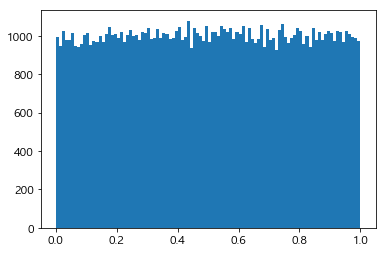

In [6]:
plt.hist(a.flatten(), bins=100)
plt.show()

In [7]:
heads_proba = 0.51
coin_tosses = a < heads_proba

In [8]:
print(coin_tosses)

[[ True False  True ... False  True False]
 [ True  True  True ... False  True  True]
 [False  True  True ... False False  True]
 ...
 [ True False False ... False  True  True]
 [False False False ...  True  True  True]
 [False False  True ...  True False  True]]


In [9]:
coin_tosses = coin_tosses.astype(np.int32)
print(coin_tosses)

[[1 0 1 ... 0 1 0]
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 0 0 1]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 1 ... 1 0 1]]


In [10]:
coin_tosses.shape

(10000, 10)

In [11]:
print("numpy cumsum\n", np.cumsum(coin_tosses))
print()
print("axis=1")
print(np.cumsum(coin_tosses, axis=1))
print()
print("axis=0")
print(np.cumsum(coin_tosses, axis=0))

numpy cumsum
 [    1     1     2 ... 50874 50874 50875]

axis=1
[[1 1 2 ... 3 4 4]
 [1 2 3 ... 5 6 7]
 [0 1 2 ... 5 5 6]
 ...
 [1 1 1 ... 4 5 6]
 [0 0 0 ... 2 3 4]
 [0 0 1 ... 4 4 5]]

axis=0
[[   1    0    1 ...    0    1    0]
 [   2    1    2 ...    0    2    1]
 [   2    2    3 ...    0    2    2]
 ...
 [5123 5053 5092 ... 5064 5134 5107]
 [5123 5053 5092 ... 5065 5135 5108]
 [5123 5053 5093 ... 5066 5135 5109]]


In [12]:
print(np.arange(1,10001).reshape(-1,1))

[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]


In [13]:
cum_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1,10001).reshape(-1,1)
print(cum_heads_ratio)

[[1.         0.         1.         ... 0.         1.         0.        ]
 [1.         0.5        1.         ... 0.         1.         0.5       ]
 [0.66666667 0.66666667 1.         ... 0.         0.66666667 0.66666667]
 ...
 [0.51240248 0.50540108 0.50930186 ... 0.5065013  0.5135027  0.51080216]
 [0.51235124 0.50535054 0.50925093 ... 0.50655066 0.51355136 0.51085109]
 [0.5123     0.5053     0.5093     ... 0.5066     0.5135     0.5109    ]]


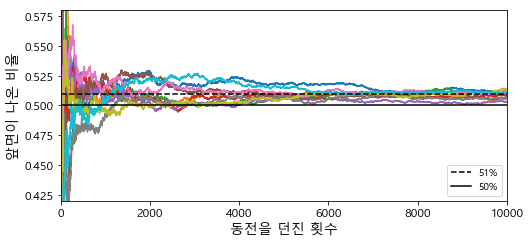

In [14]:
plt.figure(figsize=(8,3.5))
plt.plot(cum_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

In [15]:
from scipy.stats import binom
1 - binom.cdf(499, 1000, 0.51)

0.7467502275561786

In [16]:
1 - binom.cdf(4999, 10000, 0.51)

0.9777976478701533

## 2. Data Load and Train/Test Split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [18]:
X, y = make_moons(n_samples = 500, noise = 0.3, random_state = 42)

(500, 2)


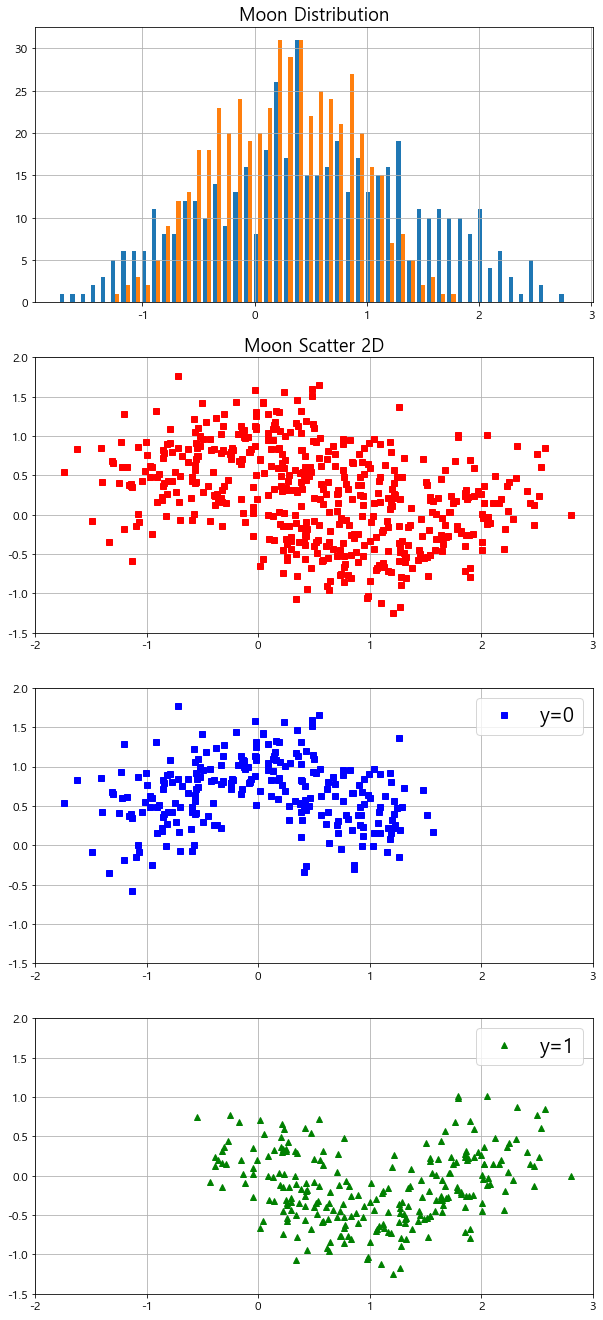

In [19]:
fig = plt.figure()
fig.set_size_inches((10,20))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

ax1.grid(True, which="both")
ax2.grid(True, which="both")
ax3.grid(True, which="both")
ax4.grid(True, which="both")

plt.subplots_adjust(bottom=0.0001)
ax1.hist(X, bins=50)
ax1.set_title("Moon Distribution", size=18)
ax2.plot(X[:,0], X[:,1], "rs")
ax2.set_title("Moon Scatter 2D", size=18)
ax3.plot(X[:,0][y==0], X[:,1][y==0], "bs", label="y=0")
ax4.plot(X[:,0][y==1], X[:,1][y==1], "g^", label="y=1")

ax2.axis([-2,3,-1.5,2])
ax3.axis([-2,3,-1.5,2])
ax4.axis([-2,3,-1.5,2])
ax3.legend(fontsize=20)
ax4.legend(fontsize=20)

print(X.shape)

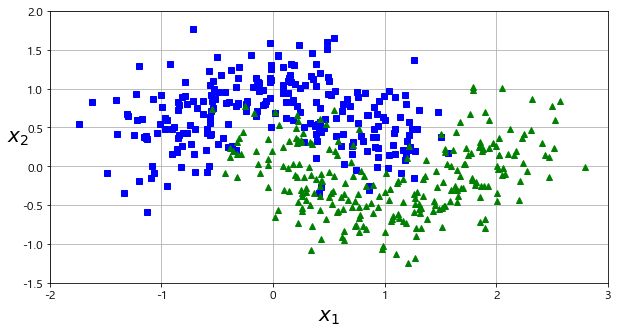

In [20]:
fig = plt.figure()
fig.set_size_inches((10,5))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

plt.axis([-2,3,-1.5,2])
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
print("X_train\t: {}".format(X_train.shape))
print("X_test\t: {}".format(X_test.shape))
print("y_train\t: {}".format(y_train.shape))
print("y_test\t: {}".format(y_test.shape))

X_train	: (375, 2)
X_test	: (125, 2)
y_train	: (375,)
y_test	: (125,)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
dct_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
gnb_clf = GaussianNB()
knn_clf = KNeighborsClassifier(n_neighbors=31)
svm_clf = SVC(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

voting_clf_1 = VotingClassifier(
    estimators=[("lr", log_clf),("dt", dct_clf),("nb", gnb_clf),
               ("knn", knn_clf),("svm", svm_clf),("rf", rf_clf)],
    voting="hard")
svm_clf2 = SVC(random_state=42, probability=True)
voting_clf_2 = VotingClassifier(
    estimators=[("lr", log_clf),("svm", svm_clf2),("rf", rf_clf)],
    voting="soft")

In [24]:
voting_clf_1.fit(X_train, y_train)
voting_clf_2.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm', SVC(C=1....stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [25]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [26]:
from sklearn.metrics import accuracy_score
classifier_set = [log_clf, dct_clf, gnb_clf, knn_clf, \
                  svm_clf, rf_clf, voting_clf_1, voting_clf_2]
for clf in classifier_set:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
GaussianNB 0.856
KNeighborsClassifier 0.904
SVC 0.888
RandomForestClassifier 0.872
VotingClassifier 0.896
VotingClassifier 0.912


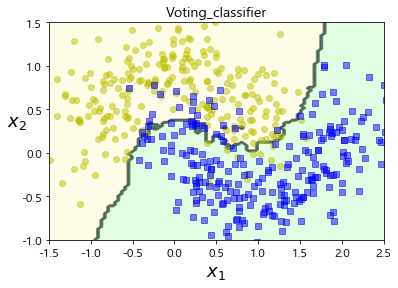

In [32]:
plt.figure(figsize=(6,4))
plot_decision_boundary(voting_clf_2, X, y)
plt.title("Voting_classifier", fontsize=14)
plt.show()

맨 마지막의 VotingClassifier는 voting=soft로 지정하여 확률이 높은 투표에 비중을 둠

## 3. 배깅 앙상블

#### Bagging : 중복을 허용하여 샘플링
#### pasting : 중복을 허용하지 않고 샘플링

#### 배깅만이 한 예측기를 위해 같은훈련 샘플을 여러 번 샘플링 가능

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score
print("배깅) test 셋의 정확도는? : {}".format(accuracy_score(y_test, y_pred)))

배깅) test 셋의 정확도는? : 0.904


In [30]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("결정 트리) test 셋의 정확도는? : {}".format(accuracy_score(y_test, y_pred_tree)))

결정 트리) test 셋의 정확도는? : 0.856


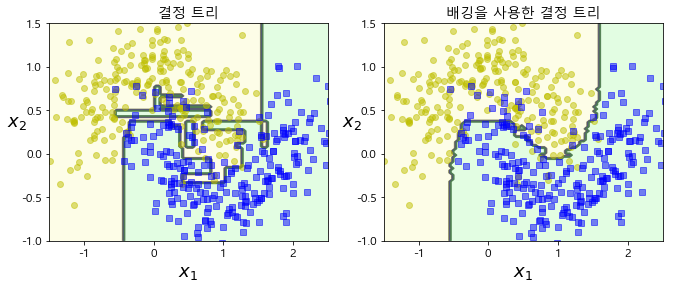

In [31]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

#### 위의 그림은 어떻게 그려졌나?

In [34]:
axes=[-1.5, 2.5, -1, 1.5]
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)

In [35]:
print("x1 :",x1.shape,", x2 :",x2.shape,", x1s :",x1s.shape,", x2s :",x2s.shape)

x1 : (100, 100) , x2 : (100, 100) , x1s : (100,) , x2s : (100,)


In [36]:
X_new = np.c_[x1.ravel(), x2.ravel()]

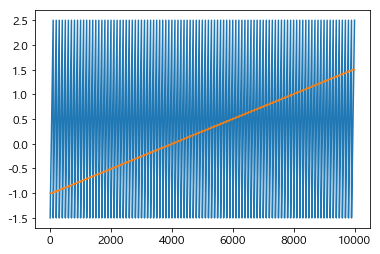

In [37]:
plt.plot(X_new)
plt.show()

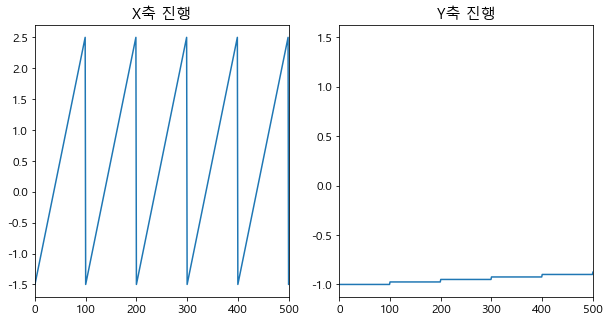

In [38]:
fig = plt.figure()
fig.set_size_inches((10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(X_new[:,0])
ax1.set_xlim(0,500)
ax1.set_title("X축 진행", size=15)
ax2.plot(X_new[:,1])
ax2.set_xlim(0,500)
ax2.set_title("Y축 진행", size=15)
plt.show()

In [39]:
clf.predict(X_new).reshape(100,100)

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int64)

## 4. RandomForest

- RandomForest : Decision Tree를 여러 개 모은 앙상블 모델. Bagging과의 차이점은 특성을 무작위로 선택 후 최적의 특성을 찾는 식으로 무작위성을 추가로 주입

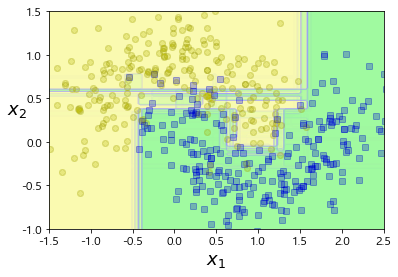

In [53]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [43]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [44]:
bag_clf2 = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf2.fit(X_train, y_train)
y_pred = bag_clf2.predict(X_test)

In [45]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

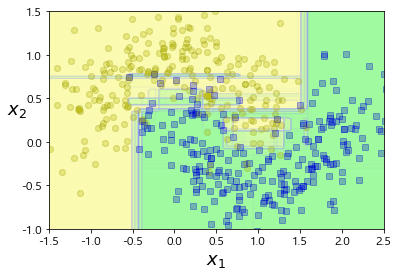

In [46]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

Text(0.5,1,'배깅으로 만든 랜덤 포래스트')

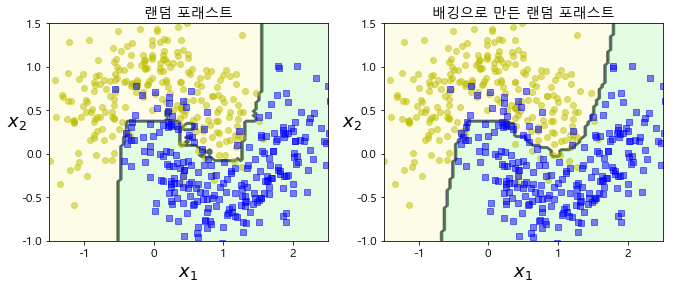

In [47]:
indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(rnd_clf, X, y)
plt.title("랜덤 포래스트", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf2, X, y)
plt.title("배깅으로 만든 랜덤 포래스트", fontsize=14)

In [49]:
rnd_clf.fit(X_train, y_train)
bag_clf2.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
y_pred2 = bag_clf2.predict(X_test)
print(accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred2))

0.912 0.92


## 5. oob(Out of Bag) 평가

- m개의 sample이 존재한다고 가정
- 무작위로 하나를 추출할 때 선택되지 않을 확률은 1 - 1/m
- 이를 m번 반복할 경우 확률은 (1-1/m)^m
- 이를 log를 씌우고 로피탈의 정리를 사용하면 확률은 e^-1 = 0.36788가 됨
- 즉, 샘플링될 확률은 약 63%, 안 될 확률은 약 37%
- 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 부름

In [50]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [51]:
print(bag_clf.oob_decision_function_)
# 각 label별 확률 반환

[[0.31746032 0.68253968]
 [0.34117647 0.65882353]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.08379888 0.91620112]
 [0.31693989 0.68306011]
 [0.02923977 0.97076023]
 [0.97687861 0.02312139]
 [0.97765363 0.02234637]
 [0.74404762 0.25595238]
 [0.         1.        ]
 [0.71195652 0.28804348]
 [0.83957219 0.16042781]
 [0.97777778 0.02222222]
 [0.0625     0.9375    ]
 [0.         1.        ]
 [0.97297297 0.02702703]
 [0.95238095 0.04761905]
 [1.         0.        ]
 [0.01704545 0.98295455]
 [0.38947368 0.61052632]
 [0.88700565 0.11299435]
 [1.         0.        ]
 [0.96685083 0.03314917]
 [0.         1.        ]
 [0.99428571 0.00571429]
 [1.         0.        ]
 [0.         1.        ]
 [0.64804469 0.35195531]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.13402062 0.86597938]
 [1.         0.        ]
 [0.         1.        ]
 [0.36065574 0.63934426]
 [0.         1.        ]
 [1.         0.        ]


In [52]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 6. 특성 중요도

In [54]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [55]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [56]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

<2018년 7월 2일 Hands on Machin Learning 세미나 chap.3 mnist 예시 program>

본 프로그램은 mnist dataset의 숫자들을 유저가 알아맞추는 프로그램입니다.
중간에 "0"을 눌러 프로그램을 종료할 수 있습니다.
본 프로그램의 오더에 따라 알맞은 값을 입력해주세요.

1~70000까지의 숫자를 입력하세요 : 500


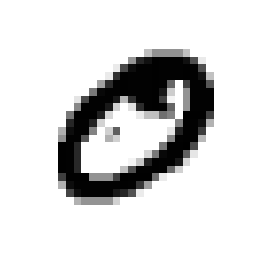

다음 그림의 숫자는 무엇일까요? [0~9] :0
맞았습니다! 재도전?(Y/N) :n
프로그램을 종료합니다.


In [57]:
from mnist_human import *
main()

In [58]:
rnd_clf.feature_importances_.shape

(784,)

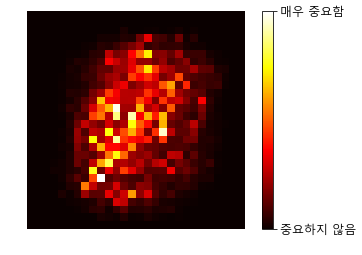

In [59]:
image = rnd_clf.feature_importances_.reshape(28,28)
plt.imshow(image, cmap=matplotlib.cm.hot, interpolation="nearest")
plt.axis("off")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                          rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["중요하지 않음", "매우 중요함"])
plt.show()

## 7. Boost

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 학습 기법

### 7-1. AdaBoost

- 이전 모델이 과소적합했던 샘플(틀린 샘플)의 가중치를 높임
- 이렇게 되면 새로운 예측기는 학습하기 어려운 샘플에 집중을 하게 됨

In [60]:
s500 = np.ones(500) / 500
print(s500[:10])
print(s500.shape)

[0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002]
(500,)


In [61]:
result = np.random.normal(0,1,500)
result = (result > 0.5).astype(np.int32)
print(result[:10])

[0 1 0 0 1 0 0 0 0 0]


In [62]:
s500 = np.concatenate((s500.reshape(1,-1), result.reshape(1,-1)))

In [63]:
# 500개의 sample의 weight
s500[0][:20]

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002])

In [64]:
# 500개의 sample의 Y
s500[1][:20]

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.])

In [65]:
pred = (np.random.normal(0,1,500) > 0.5).astype(np.int32)

In [66]:
s500[0][pred != s500[1]]
error_ratio = sum(s500[0][pred != s500[1]]) / sum(s500[0])

In [67]:
error_ratio

0.42800000000000005

In [68]:
learning_rate = 0.01
# error_ratio = 0.6
pred_weighted = learning_rate * np.log((1-error_ratio)/error_ratio)

In [69]:
pred_weighted

0.0029001579579800096

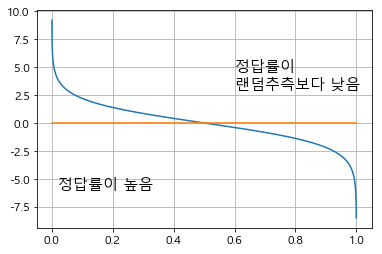

In [70]:
x_log = np.arange(1,9999) / 10000
y_log = [np.log((1-v)/v) for v in x_log]
plt.plot(x_log, y_log)
plt.plot(x_log, np.zeros(9998))
plt.grid(True)
plt.text(0.6,3,"정답률이 \n랜덤추측보다 낮음", size=15)
plt.text(0.02,-6,"정답률이 높음", size=15)
plt.show()

- 결과값의 선형 결합으로 모델 구성
- 예측은 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 결과를 만든 후 가중치의 합이 가장 큰 클래스가 예측 결과가 됨

In [71]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

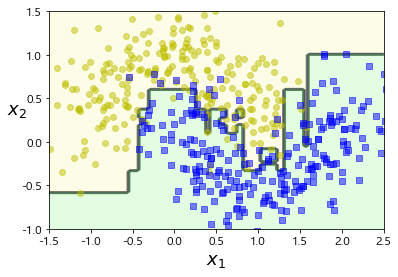

In [72]:
plot_decision_boundary(ada_clf, X, y)

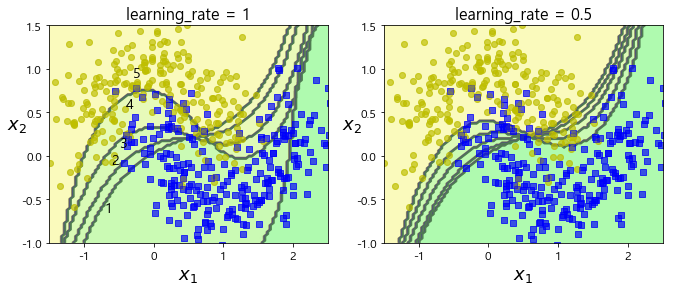

In [73]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

### 7-2. Gradient Boosting

- sample의 가중치를 수정하는 대신 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [74]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

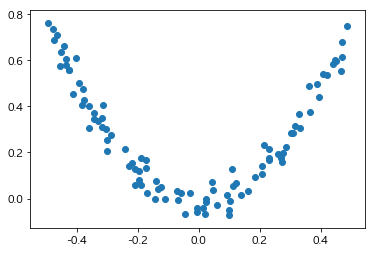

In [75]:
plt.scatter(X, y)
plt.show()

In [76]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [77]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

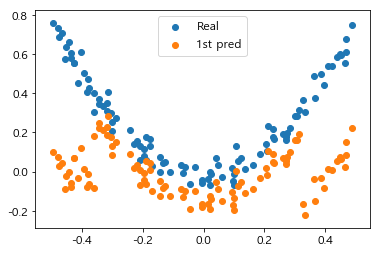

In [78]:
plt.scatter(X, y, label="Real")
plt.scatter(X, y2, label="1st pred")
plt.legend(loc="upper center", fontsize=12)
plt.show()

In [79]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

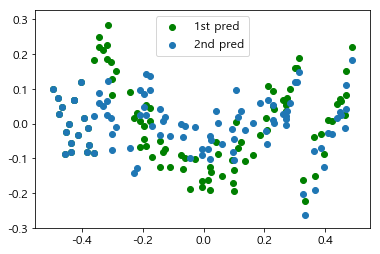

In [80]:
#plt.scatter(X, y, label="Real")
plt.scatter(X, y2, label="1st pred", color = "g")
plt.scatter(X, y3, label="2nd pred")
plt.legend(loc="upper center", fontsize=12)
plt.show()

In [81]:
y4 = y3 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
y5 = y4 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
y6 = y5 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)
y7 = y6 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

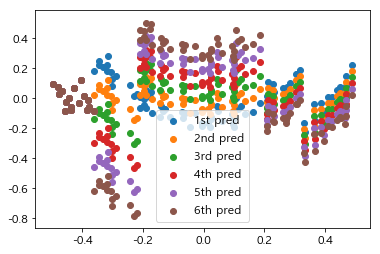

In [82]:
#plt.scatter(X, y, label="Real")
plt.scatter(X, y2, label="1st pred")
plt.scatter(X, y3, label="2nd pred")
plt.scatter(X, y4, label="3rd pred")
plt.scatter(X, y5, label="4th pred")
plt.scatter(X, y6, label="5th pred")
plt.scatter(X, y7, label="6th pred")
plt.legend(loc="lower center", fontsize=12)
plt.show()

In [83]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

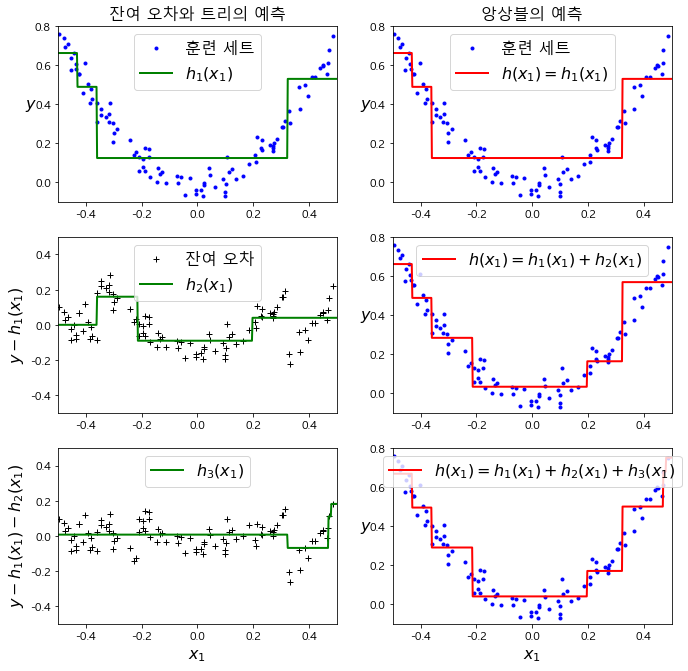

In [84]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [86]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

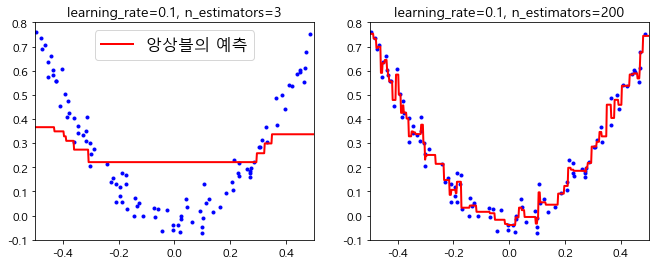

In [87]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

## 조기 종료를 사용한 그래디언트 부스팅

In [88]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
# staged_predict 메서드 : 훈련의 각 단계에서 앙상블에 의해 만들어진
# 예측기를 순회하는 반복자를반환
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [89]:
X_val.shape, y_val.shape

((25, 1), (25,))

In [90]:
X_train.shape, y_train.shape

((75, 1), (75,))

In [91]:
min_error = np.min(errors)
len(errors)

120

In [92]:
np.argmin(errors)

55

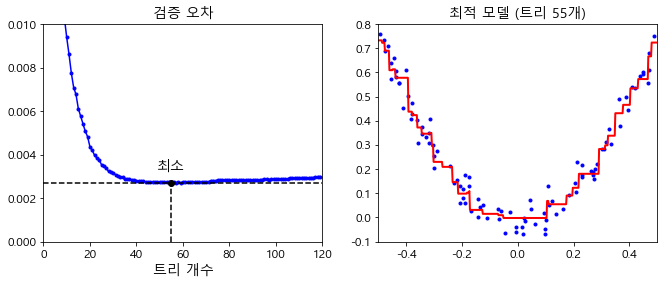

In [93]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

plt.show()

In [94]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

# warm_start = True, 기존 트리를 유지하고 훈련을 할 수 있게해줌

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [95]:
print(gbrt.n_estimators)

61


In [96]:
print("최소 검증 MSE:", min_val_error)

최소 검증 MSE: 0.002712853325235463


## XGBoost

In [97]:
import xgboost
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("검증 MSE:", val_error),

검증 MSE: 0.0028512559726563943


In [98]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("검증 MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

In [99]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

11.3 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

12.1 ms ± 90 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 스태킹 앙상블

In [101]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [102]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [103]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
#from sklearn.neural_network import MLPClassifier
random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
#mlp_clf = MLPClassifier(random_state=42)

In [104]:
estimators = [random_forest_clf, extra_trees_clf]

In [105]:
for estimator in estimators:
    print("훈련 예측기: ", estimator)
    estimator.fit(X_train, y_train)

훈련 예측기:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
훈련 예측기:  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [106]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9467, 0.9512]

In [107]:
from sklearn.ensemble import VotingClassifier
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
]
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
voting_clf.score(X_val, y_val)

0.9442

In [108]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9467, 0.9512]

In [109]:
voting_clf.voting = "soft"

In [110]:
voting_clf.score(X_val, y_val)

0.9625

In [111]:
voting_clf.score(X_test, y_test)

0.9582

In [112]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9434, 0.9444]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요.

In [113]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [114]:
X_val_predictions

array([[2., 2.],
       [7., 7.],
       [4., 4.],
       ...,
       [4., 4.],
       [9., 9.],
       [4., 4.]], dtype=float32)

In [115]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [116]:
rnd_forest_blender.oob_score_

0.9516

In [117]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [118]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [119]:
from sklearn.metrics import accuracy_score

In [120]:
accuracy_score(y_test, y_pred)

0.9448